In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install bambi

In [ ]:
import bambi as bmb

# Context

I decided to look at what variables impact the size of forestfires, to figure out what is the most important to prioritize when predicting future natural disasters. I got my data set from https://archive.ics.uci.edu/dataset/162/forest+fires.

In [ ]:
forestfiresog = pd.read_csv('https://raw.githubusercontent.com/anyaweintraub/datasciencefoundationsA3/refs/heads/main/forestfires.csv')

In [ ]:
forestfiresog

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
forestfires = forestfiresog.drop(columns=['X', 'Y', 'month', 'day', 'RH', 'ISI'])

In [ ]:
forestfires = forestfires.query('area < 300')

In [ ]:
forestfires

,FFMC,DMC,DC,temp,wind,rain,area
0,86.2,26.2,94.3,8.2,6.7,0.0,0.00
1,90.6,35.4,669.1,18.0,0.9,0.0,0.00
2,90.6,43.7,686.9,14.6,1.3,0.0,0.00
3,91.7,33.3,77.5,8.3,4.0,0.2,0.00
4,89.3,51.3,102.2,11.4,1.8,0.0,0.00
...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,27.8,2.7,0.0,6.44
513,81.6,56.7,665.6,21.9,5.8,0.0,54.29
514,81.6,56.7,665.6,21.2,6.7,0.0,11.16
515,94.4,146.0,614.7,25.6,4.0,0.0,0.00


I have decided to eliminate the X and Y because I want to look overall at location, not specific to certain parts. I also have decided to eliminate day and month, as month affects certain weather conditions that I am including, as well as ISI, because it is dependent on FFMC and wind. I also decided to remove RH, relative humidity as that is affected by rain as well.

# Casual Diagram

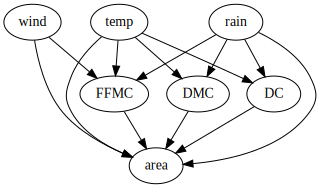

In [ ]:
s_dag = gv.Digraph(name= 'Forest Fires DAG')

s_dag.node('F','FFMC')
s_dag.node('D','DMC')
s_dag.node('C','DC')
s_dag.node('T','temp')
s_dag.node('W','wind')
s_dag.node('R','rain')
s_dag.node('A','area')

s_dag.edges(['TF', 'TD', 'TC', 'RF', 'RD', 'RC', 'WA', 'WF', 'FA', 'DA', 'CA', 'RA', 'TA'])

s_dag

# Choosing Likelihood

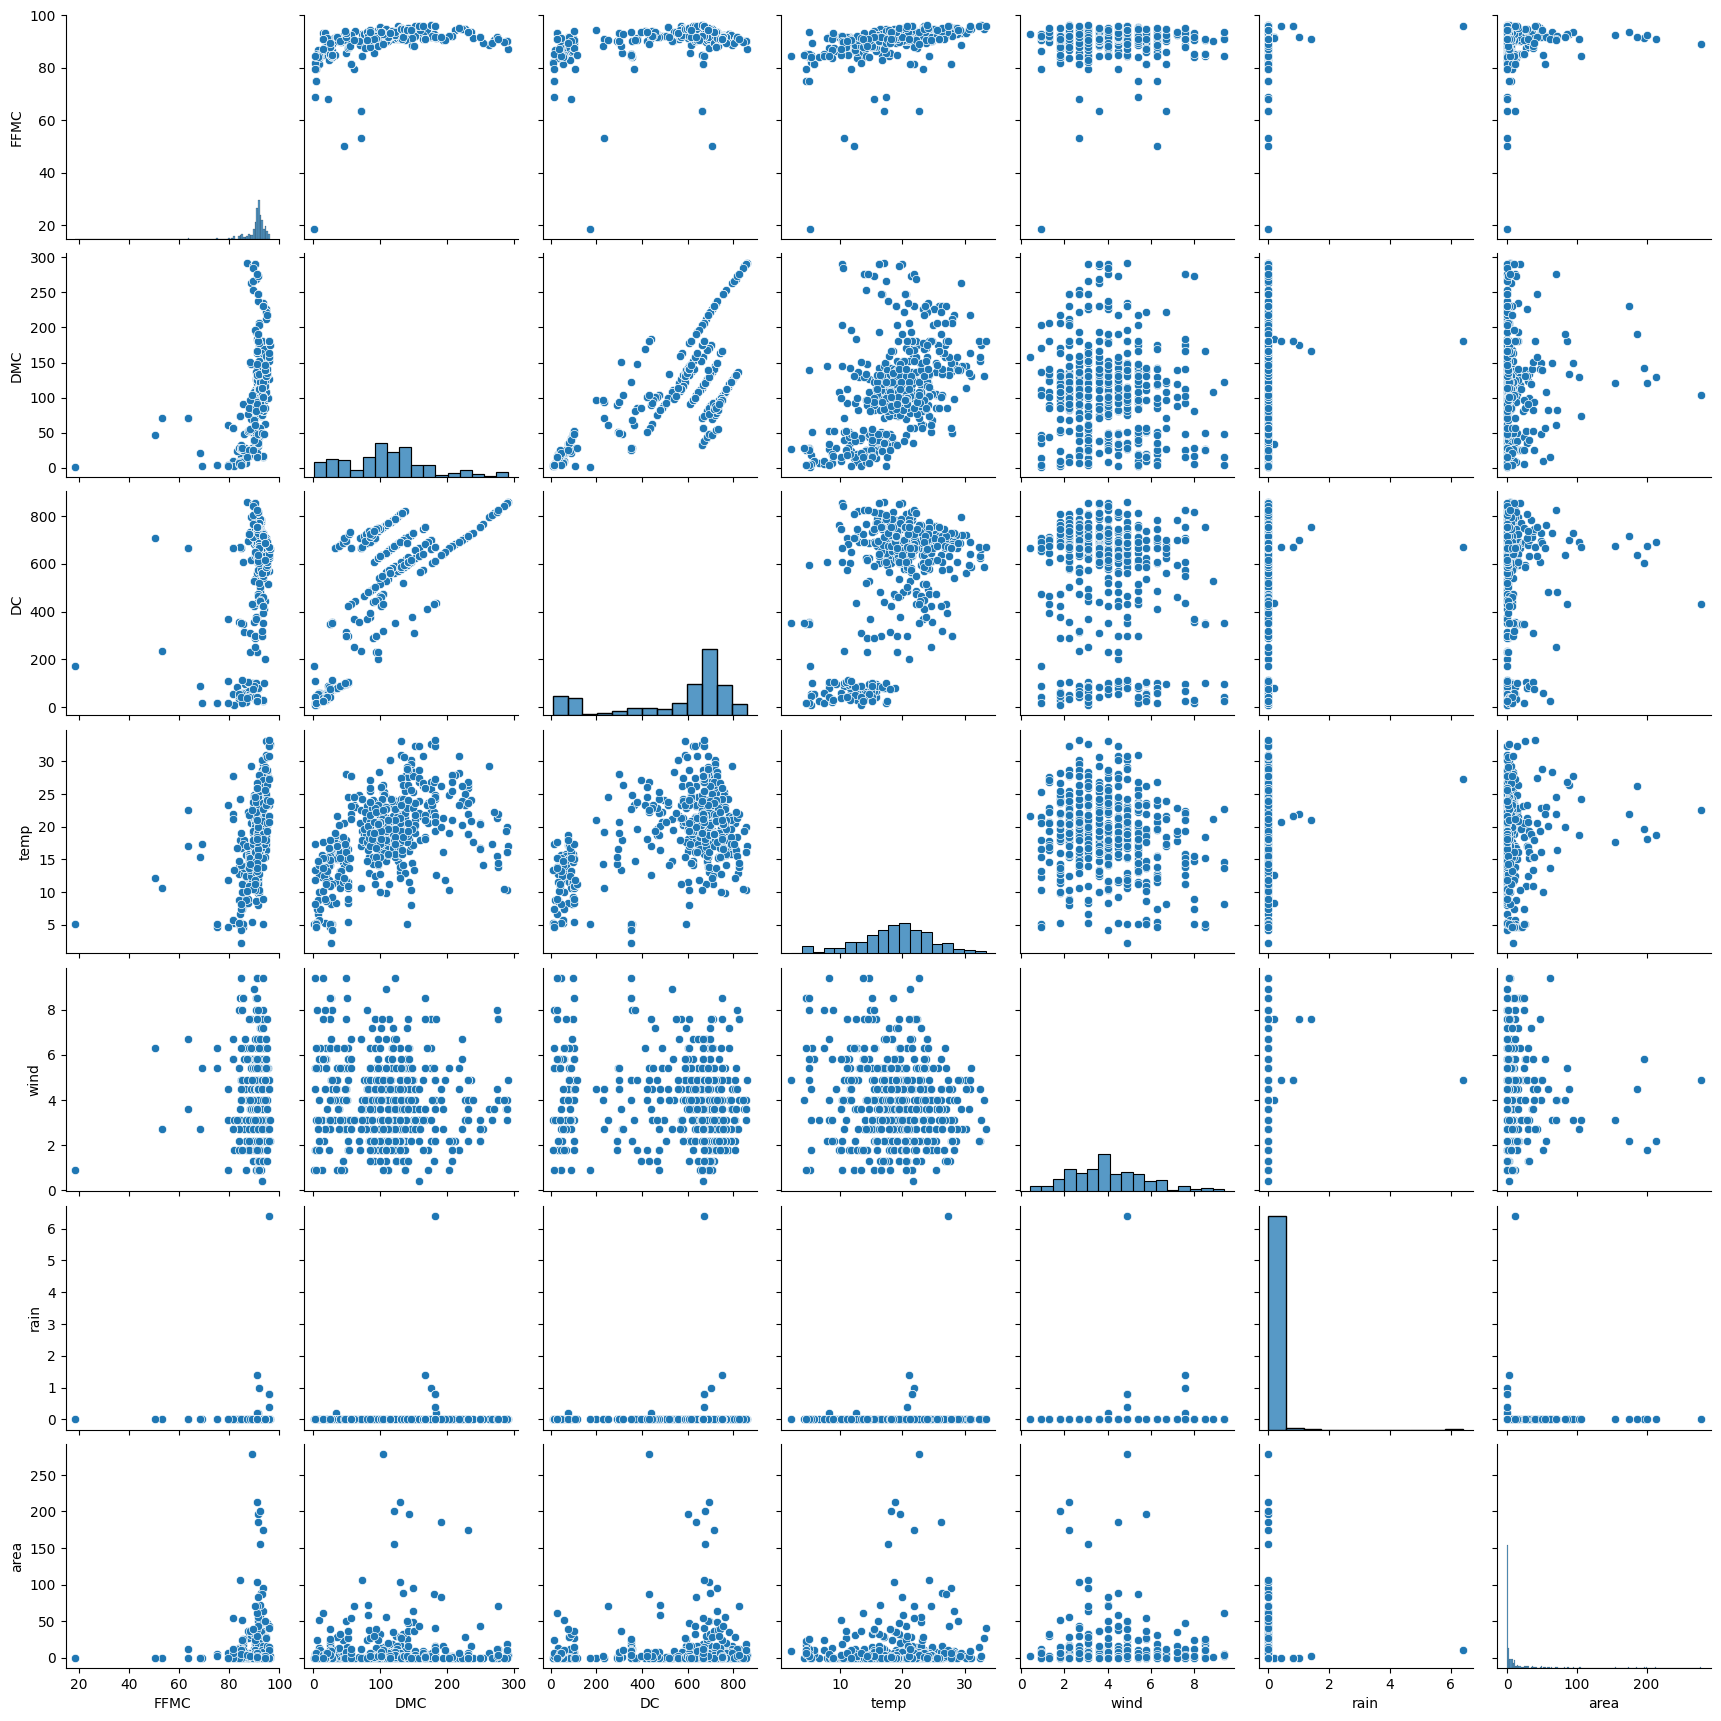

In [ ]:
sns.pairplot(forestfires)

(array([469.,  26.,   8.,   5.,   0.,   1.,   2.,   3.,   0.,   1.]),
 array([  0.   ,  27.853,  55.706,  83.559, 111.412, 139.265, 167.118,
        194.971, 222.824, 250.677, 278.53 ]),
 <BarContainer object of 10 artists>)

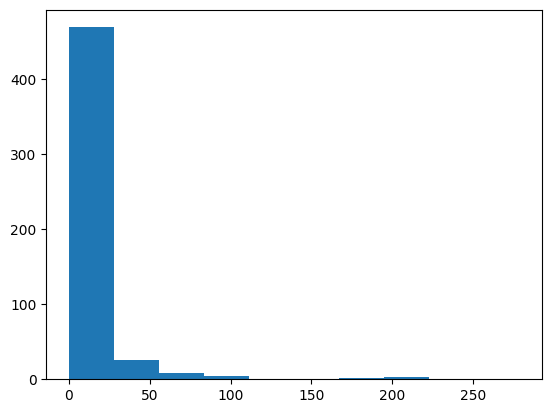

In [ ]:
plt.hist(forestfires.area)

# Model

I decided to make my first model with just wind, rain, and temperature as variables, to try to get the correct family.

In [ ]:
with pm.Model() as model_ff:

    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    β2 = pm.Normal("β2", mu=0, sigma=10)

    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * forestfires.rain + β1 * forestfires.temp + β2 * forestfires.wind))

    #likelihood
    y = pm.Exponential("y", lam=μ, observed=forestfires.area)

    #we need the log likelihood for model comparison later
    idata_ff = pm.sample(idata_kwargs={"log_likelihood":True})

In [ ]:

# posterior predictive check
pm.sample_posterior_predictive(idata_ff, model=model_ff,  extend_inferencedata=True)

<Axes: xlabel='y'>

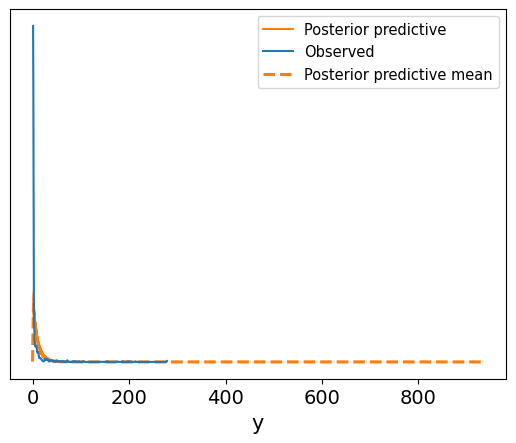

In [ ]:
az.plot_ppc(idata_ff, num_pp_samples=200, colors=["C1", "C0", "C1"])

In [ ]:
model_forestfires_bmb = bmb.Model("area ~ rain + temp + wind", forestfires)
idata_forestfires_bmb = model_forestfires_bmb.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_forestfires_bmb

       Formula: area ~ rain + temp + wind
        Family: gaussian
          Link: mu = identity
  Observations: 515
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 9.33, sigma: 278.4901)
            rain ~ Normal(mu: 0.0, sigma: 230.5881)
            temp ~ Normal(mu: 0.0, sigma: 11.7912)
            wind ~ Normal(mu: 0.0, sigma: 38.0989)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 27.3241)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

I am visualizing this model in three separate plots, as you cannot make a plot with 3 continuous variables on this platform.

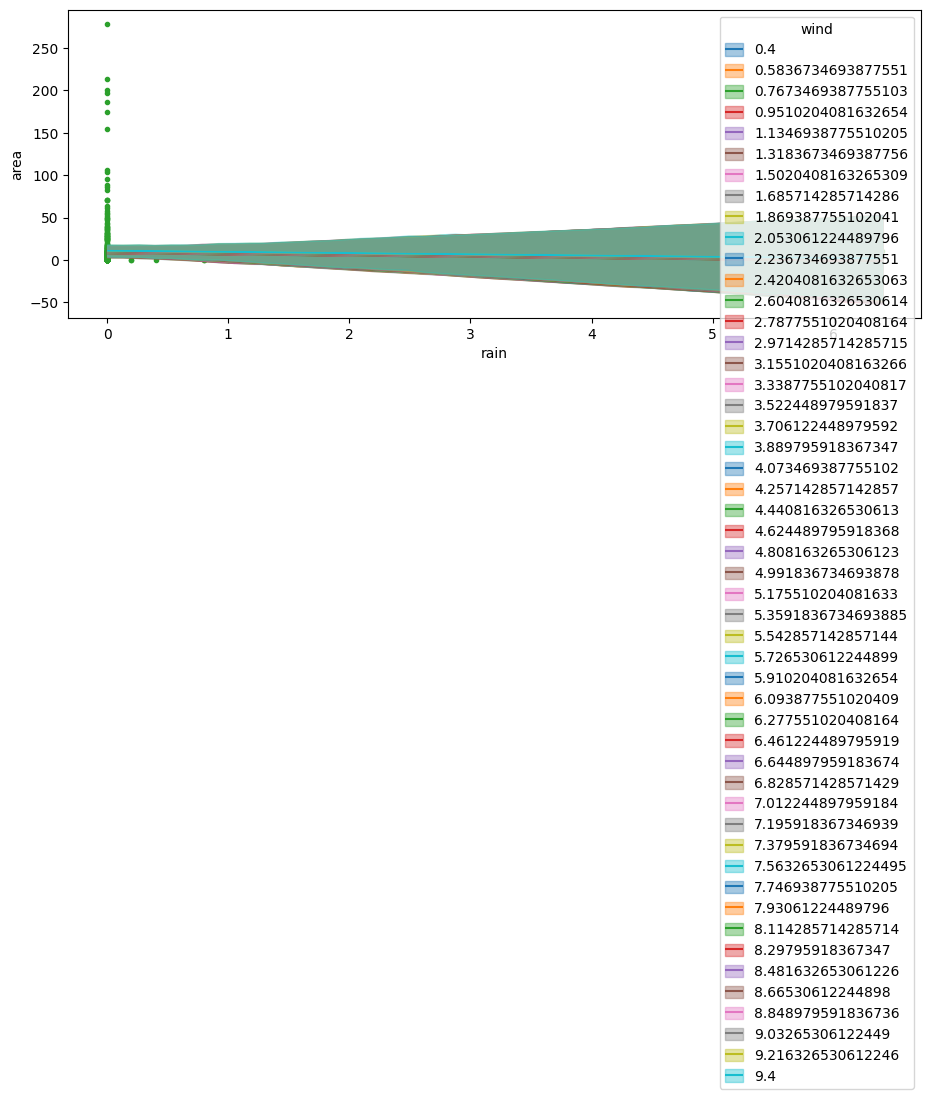

In [ ]:
bmb.interpret.plot_predictions(model_forestfires_bmb,
                               idata_forestfires_bmb,
                                ["rain", "wind"], fig_kwargs={"figsize":(11, 4)})
plt.plot(forestfires.rain, forestfires.area, "C2.", zorder=-3)

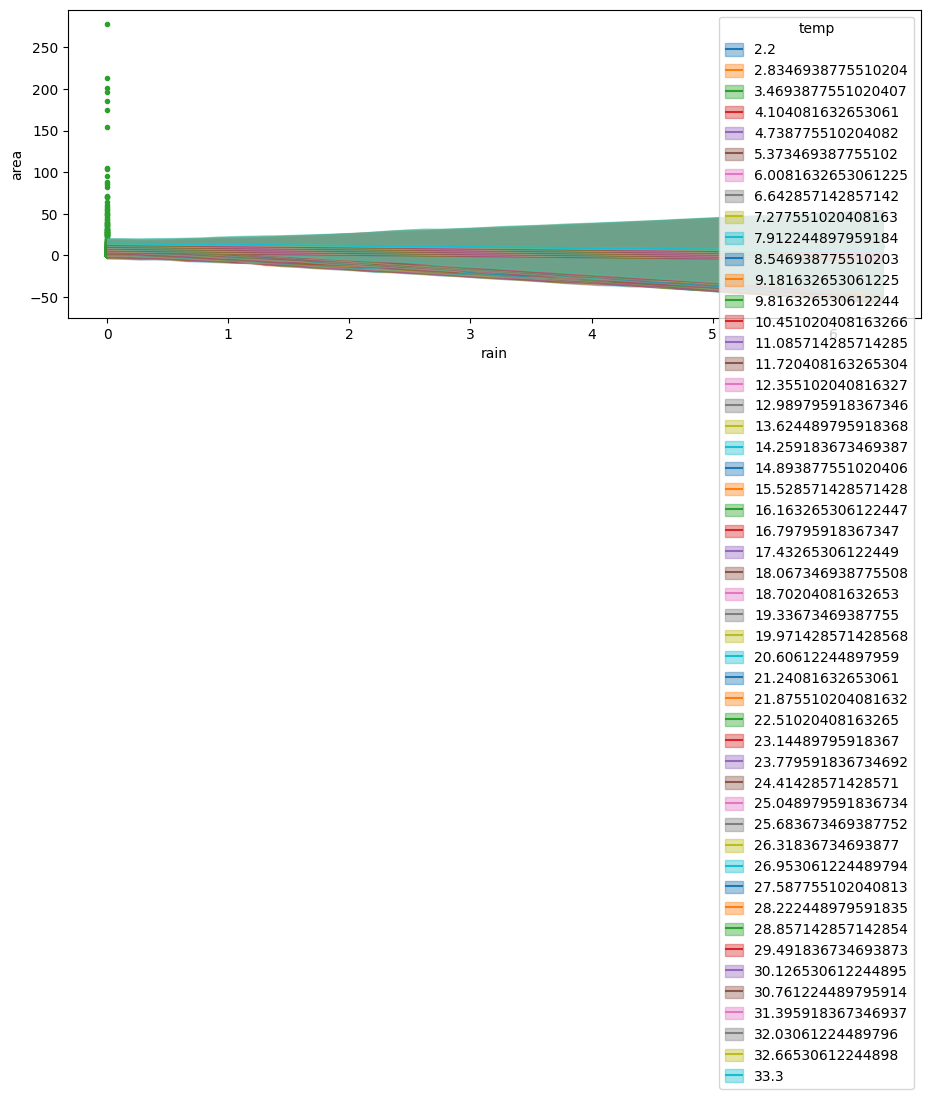

In [ ]:
bmb.interpret.plot_predictions(model_forestfires_bmb,
                               idata_forestfires_bmb,
                                ["rain", "temp"], fig_kwargs={"figsize":(11, 4)})
plt.plot(forestfires.rain, forestfires.area, "C2.", zorder=-3)

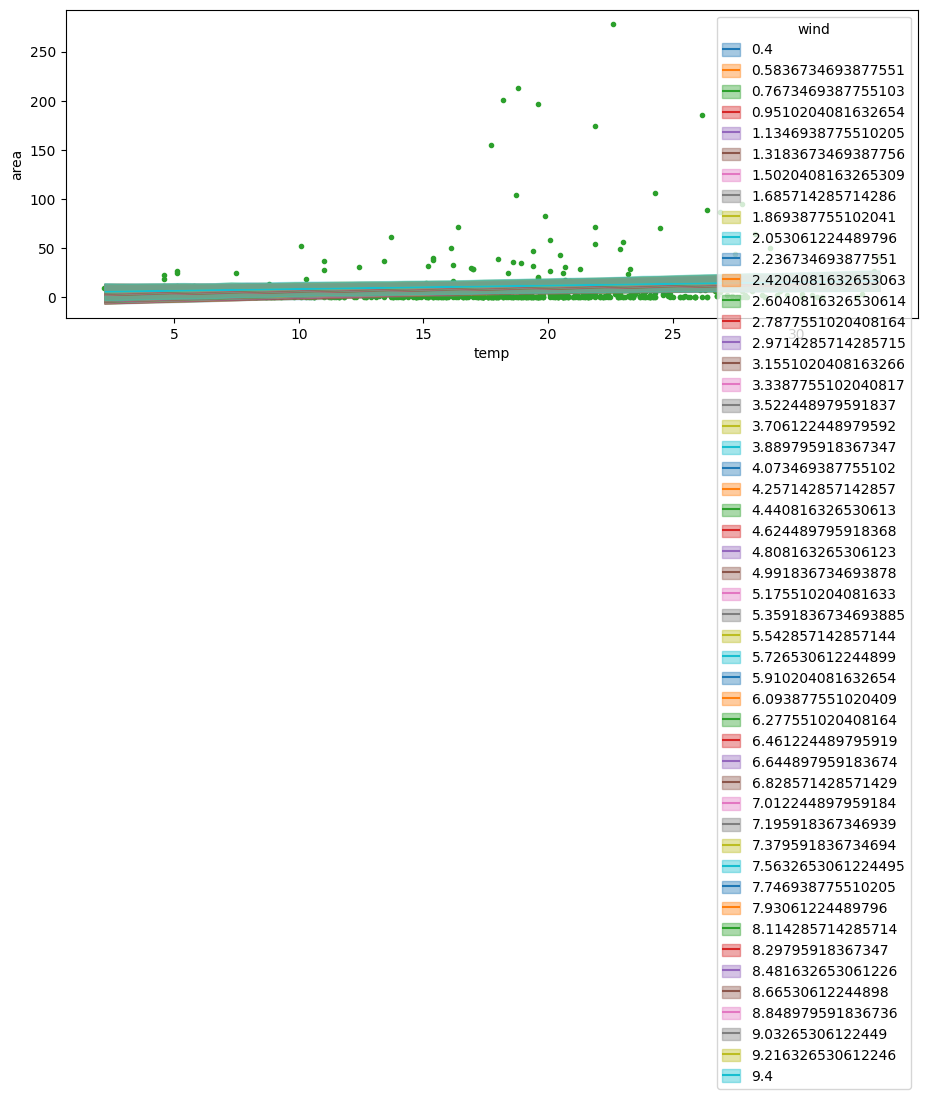

In [ ]:
bmb.interpret.plot_predictions(model_forestfires_bmb,
                               idata_forestfires_bmb,
                                ["temp", "wind"], fig_kwargs={"figsize":(11, 4)})
plt.plot(forestfires.temp, forestfires.area, "C2.", zorder=-3)

This doesn't look very good. The clear winner is the exponential distribution.

I think an interesting combination of variables to try in addition to the model above would be all of the interactions.

In [ ]:
with pm.Model() as model_ff2:

    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=100)
    β1 = pm.Normal("β1", mu=0, sigma=100)
    β2 = pm.Normal("β2", mu=0, sigma=100)
    β3 = pm.Normal("β3", mu=0, sigma=100)
    β4 = pm.Normal("β4", mu=0, sigma=100)
    β5 = pm.Normal("β5", mu=0, sigma=100)
    β6 = pm.Normal("β6", mu=0, sigma=100)
    β7 = pm.Normal("β7", mu=0, sigma=100)
    β8 = pm.Normal("β8", mu=0, sigma=100)
    β9 = pm.Normal("β9", mu=0, sigma=100)
    β10 = pm.Normal("β10", mu=0, sigma=100)


    μ = pm.Deterministic("μ", α + β0 * (forestfires.rain * forestfires.FFMC) + β1 * (forestfires.temp * forestfires.FFMC) + β2 * forestfires.wind + β3 * forestfires.FFMC + β4 * forestfires.DC + β5 * forestfires.DMC + β6 * (forestfires.rain *forestfires.DC) + β7 * (forestfires.temp * forestfires.DC )+ β8 * (forestfires.rain * forestfires.DMC) + β9 * (forestfires.temp * forestfires.DMC) + β10 * (forestfires.wind * forestfires.FFMC))

    #likelihood
    y = pm.Exponential("y", lam=μ, observed=forestfires.area)

    #we need the log likelihood for model comparison later
    idata_ff2 = pm.sample(idata_kwargs={"log_likelihood":True}, target_accept=0.997)

There are a lot of divergences (36) , but this is the best the model has run.

In [ ]:
cmp_df = az.compare(
    {"1":idata_ff,"2":idata_ff2,} )
cmp_df

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1089: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
1,0,-1.665225e+03,1.998733e+01,0.000000e+00,0.52241,6.740024e+01,0.000000e+00,False,log
2,1,-8.836972e+06,4.135695e+06,8.835307e+06,0.47759,1.238179e+06,1.238119e+06,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

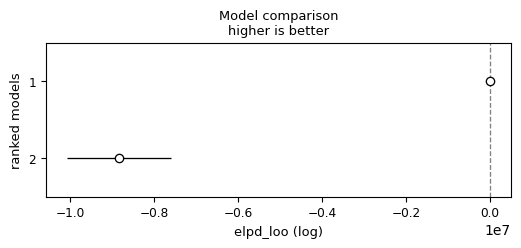

In [ ]:
az.plot_compare(cmp_df)

Model 1 is the model with only three variables, whereas Model 2 contains all the interactions. Here you can see how drastic the difference between the models is, and how the one with only wind, temp, and rain is significantly better at predicting forest fires. So, in conclusion, using only a few variables is better than adding in all other interactions between the variables. In addition, the soil moisture content levels at different depths don't seem to be good predictors either.